#  CNN model for the CIFAR-10 dataset

## Dependencies

In [3]:
! pip install torch torchvision matplotlib -q

In [4]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation

In [6]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation: Random cropping
    transforms.RandomHorizontalFlip(),    # Data augmentation: Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalization
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Normalization
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='../data/cifar10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## CNN Model

In [9]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Residual projection layers to match channel dimensions
        self.residual_proj1 = nn.Conv2d(3, 64, kernel_size=1, bias=False)
        self.residual_proj2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        self.residual_proj3 = nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False)
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully connected layers with dropout and layer normalization
        self.fc_block = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.LayerNorm(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True)
        )
        
        # Final classification layer
        self.classifier = nn.Linear(256, num_classes)
        
        # Weight initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # He initialization for convolutional layers
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Xavier initialization for fully connected layers
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Residual connections with proper projection
        identity1 = self.residual_proj1(x)
        x = self.conv_block1(x) + identity1
        
        identity2 = self.residual_proj2(x)
        x = self.conv_block2(x) + identity2
        
        identity3 = self.residual_proj3(x)
        x = self.conv_block3(x) + identity3
        
        # Global average pooling
        x = self.global_avg_pool(x).squeeze(-1).squeeze(-1)
        
        # Fully connected layers
        x = self.fc_block(x)
        
        # Classification
        x = self.classifier(x)
        
        return x

## Model Training

In [11]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(model, trainloader, criterion, optimizer, epochs=20, device="cpu"):
    train_losses = []
    train_accuracies = []
    
    start_time = time.time()
    
    print("Training model on {}...".format(device))
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate metrics for the epoch
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    end_time = time.time()
    total_training_time = end_time - start_time
    
    print(f"Total training time: {total_training_time:.2f} seconds")
    
    return train_losses, train_accuracies

In [13]:
def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color="red", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color="blue", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy Over Epochs")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [14]:
train_losses, train_accuracies = train_model(model, trainloader, criterion, optimizer, epochs=20)

Training model on cpu...
Epoch 1/20, Loss: 1.6396, Accuracy: 38.28%
Epoch 2/20, Loss: 1.2416, Accuracy: 54.91%
Epoch 3/20, Loss: 1.0762, Accuracy: 61.37%
Epoch 4/20, Loss: 0.9682, Accuracy: 65.61%
Epoch 5/20, Loss: 0.8705, Accuracy: 69.47%
Epoch 6/20, Loss: 0.8059, Accuracy: 71.80%
Epoch 7/20, Loss: 0.7378, Accuracy: 74.44%
Epoch 8/20, Loss: 0.6902, Accuracy: 76.34%
Epoch 9/20, Loss: 0.6442, Accuracy: 77.93%
Epoch 10/20, Loss: 0.6078, Accuracy: 79.20%
Epoch 11/20, Loss: 0.5708, Accuracy: 80.53%
Epoch 12/20, Loss: 0.5399, Accuracy: 81.64%
Epoch 13/20, Loss: 0.5208, Accuracy: 82.37%
Epoch 14/20, Loss: 0.4960, Accuracy: 83.12%
Epoch 15/20, Loss: 0.4772, Accuracy: 83.95%
Epoch 16/20, Loss: 0.4626, Accuracy: 84.34%
Epoch 17/20, Loss: 0.4357, Accuracy: 85.25%
Epoch 18/20, Loss: 0.4276, Accuracy: 85.49%
Epoch 19/20, Loss: 0.4123, Accuracy: 86.11%
Epoch 20/20, Loss: 0.3943, Accuracy: 86.72%
Total training time: 123660.22 seconds


In [15]:
model_base_path = "../results/model"
os.makedirs(model_base_path, exist_ok=True)

model_save_path = os.path.join(model_base_path, "cifar10_cnn_res_model_weights.pth")

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model weights saved to {model_save_path}")

Model weights saved to ../results/model/cifar10_model_weights.pth


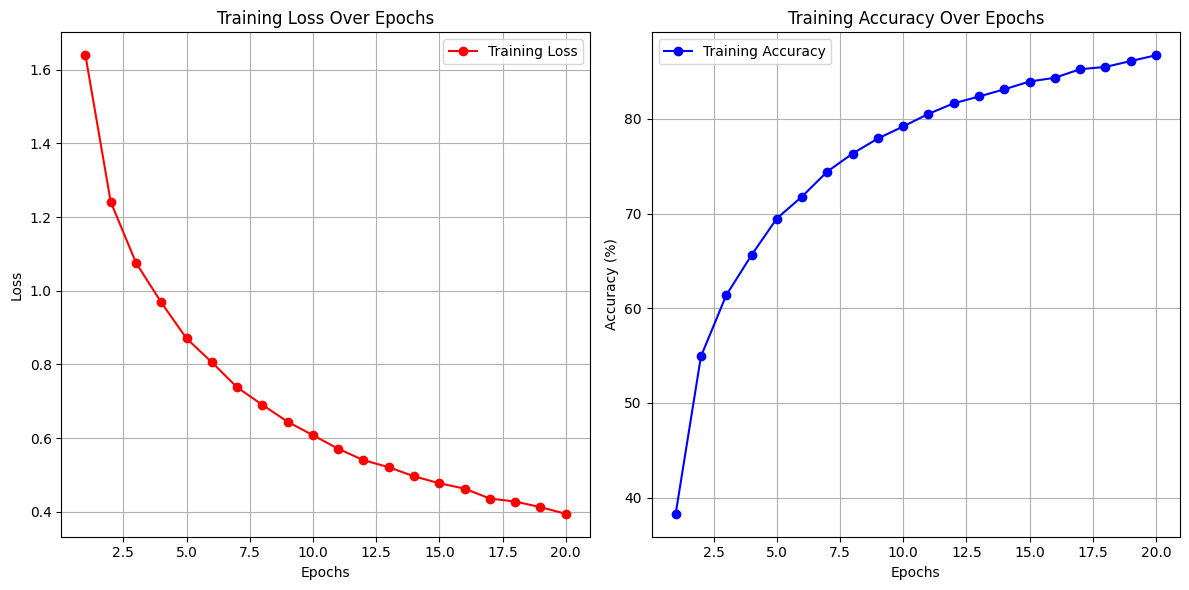

In [16]:
plot_metrics(train_losses, train_accuracies)

## Model Evaluation

In [18]:
def evaluate_model(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [19]:
def visualize_predictions(model, testloader):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Plot the images
    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = np.clip(images * 0.247 + 0.491, 0, 1)  # De-normalize for visualization

    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
        axes[i].axis('off')
    plt.show()


In [20]:
evaluate_model(model, testloader)

Test Accuracy: 85.18%


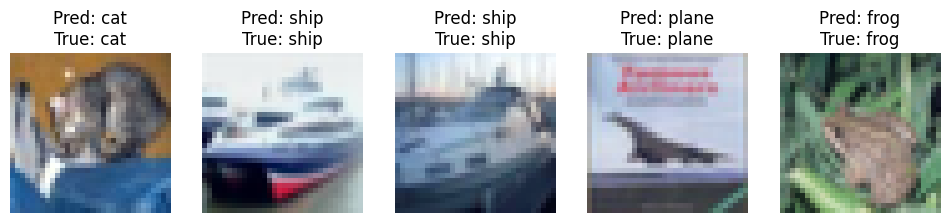

In [21]:
visualize_predictions(model, testloader)